# Comprehensive Analysis: Raw Yield vs. All Climate Stressors

**Goal:** To create an extensive dashboard of scatter plots showing the relationship between raw, un-adjusted crop yield and five key climate stressors for our four candidate regions. This will give us a complete, unfiltered view of the data to help guide our main analysis.

**Methodology:**
- We will generate one large figure for each country.
- Each figure will contain a grid of plots: one for each crop (rows) and each climate stressor (columns).
- The yield data is the raw, technology-influenced trend.
- Climate stressors are calculated as the mean (for temperature, soil water, radiation, evaporation) or sum (for precipitation) over a data-driven growing season (months with T > 10°C).

# 

--- Loading all required datasets ---
Loaded all yield data.


C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
C:\ProgramData\miniconda3\envs\climarisc\lib\site-packages\cfgrib\xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on th

Loaded all climate data.
Defined regions and growing season mask.

--- Generating dashboard for China ---


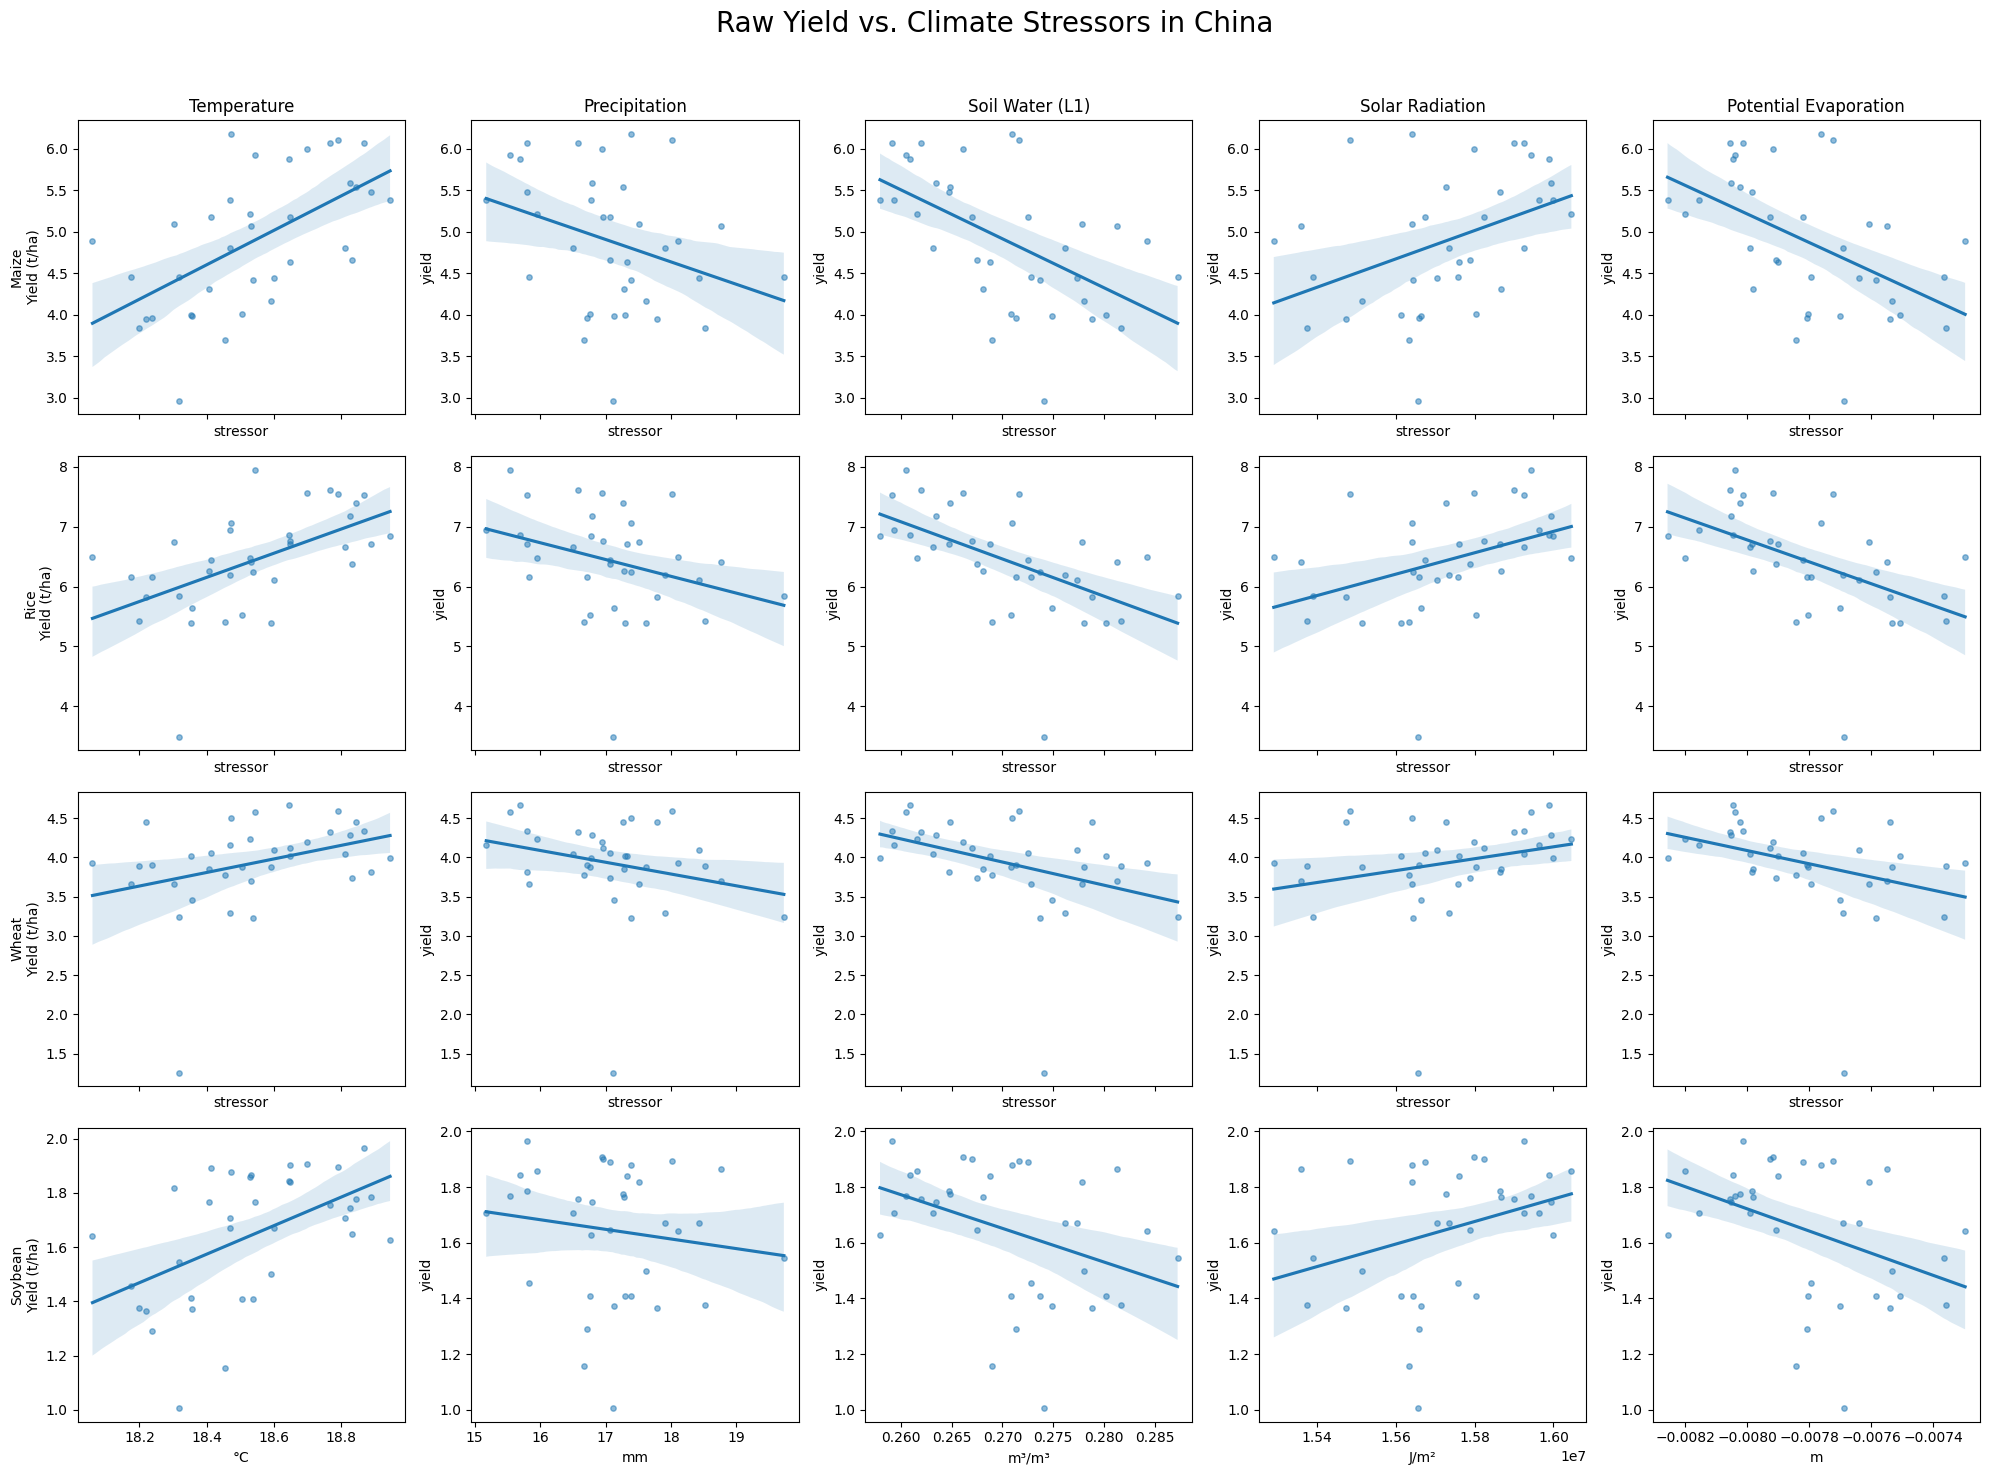


--- Generating dashboard for Italy ---


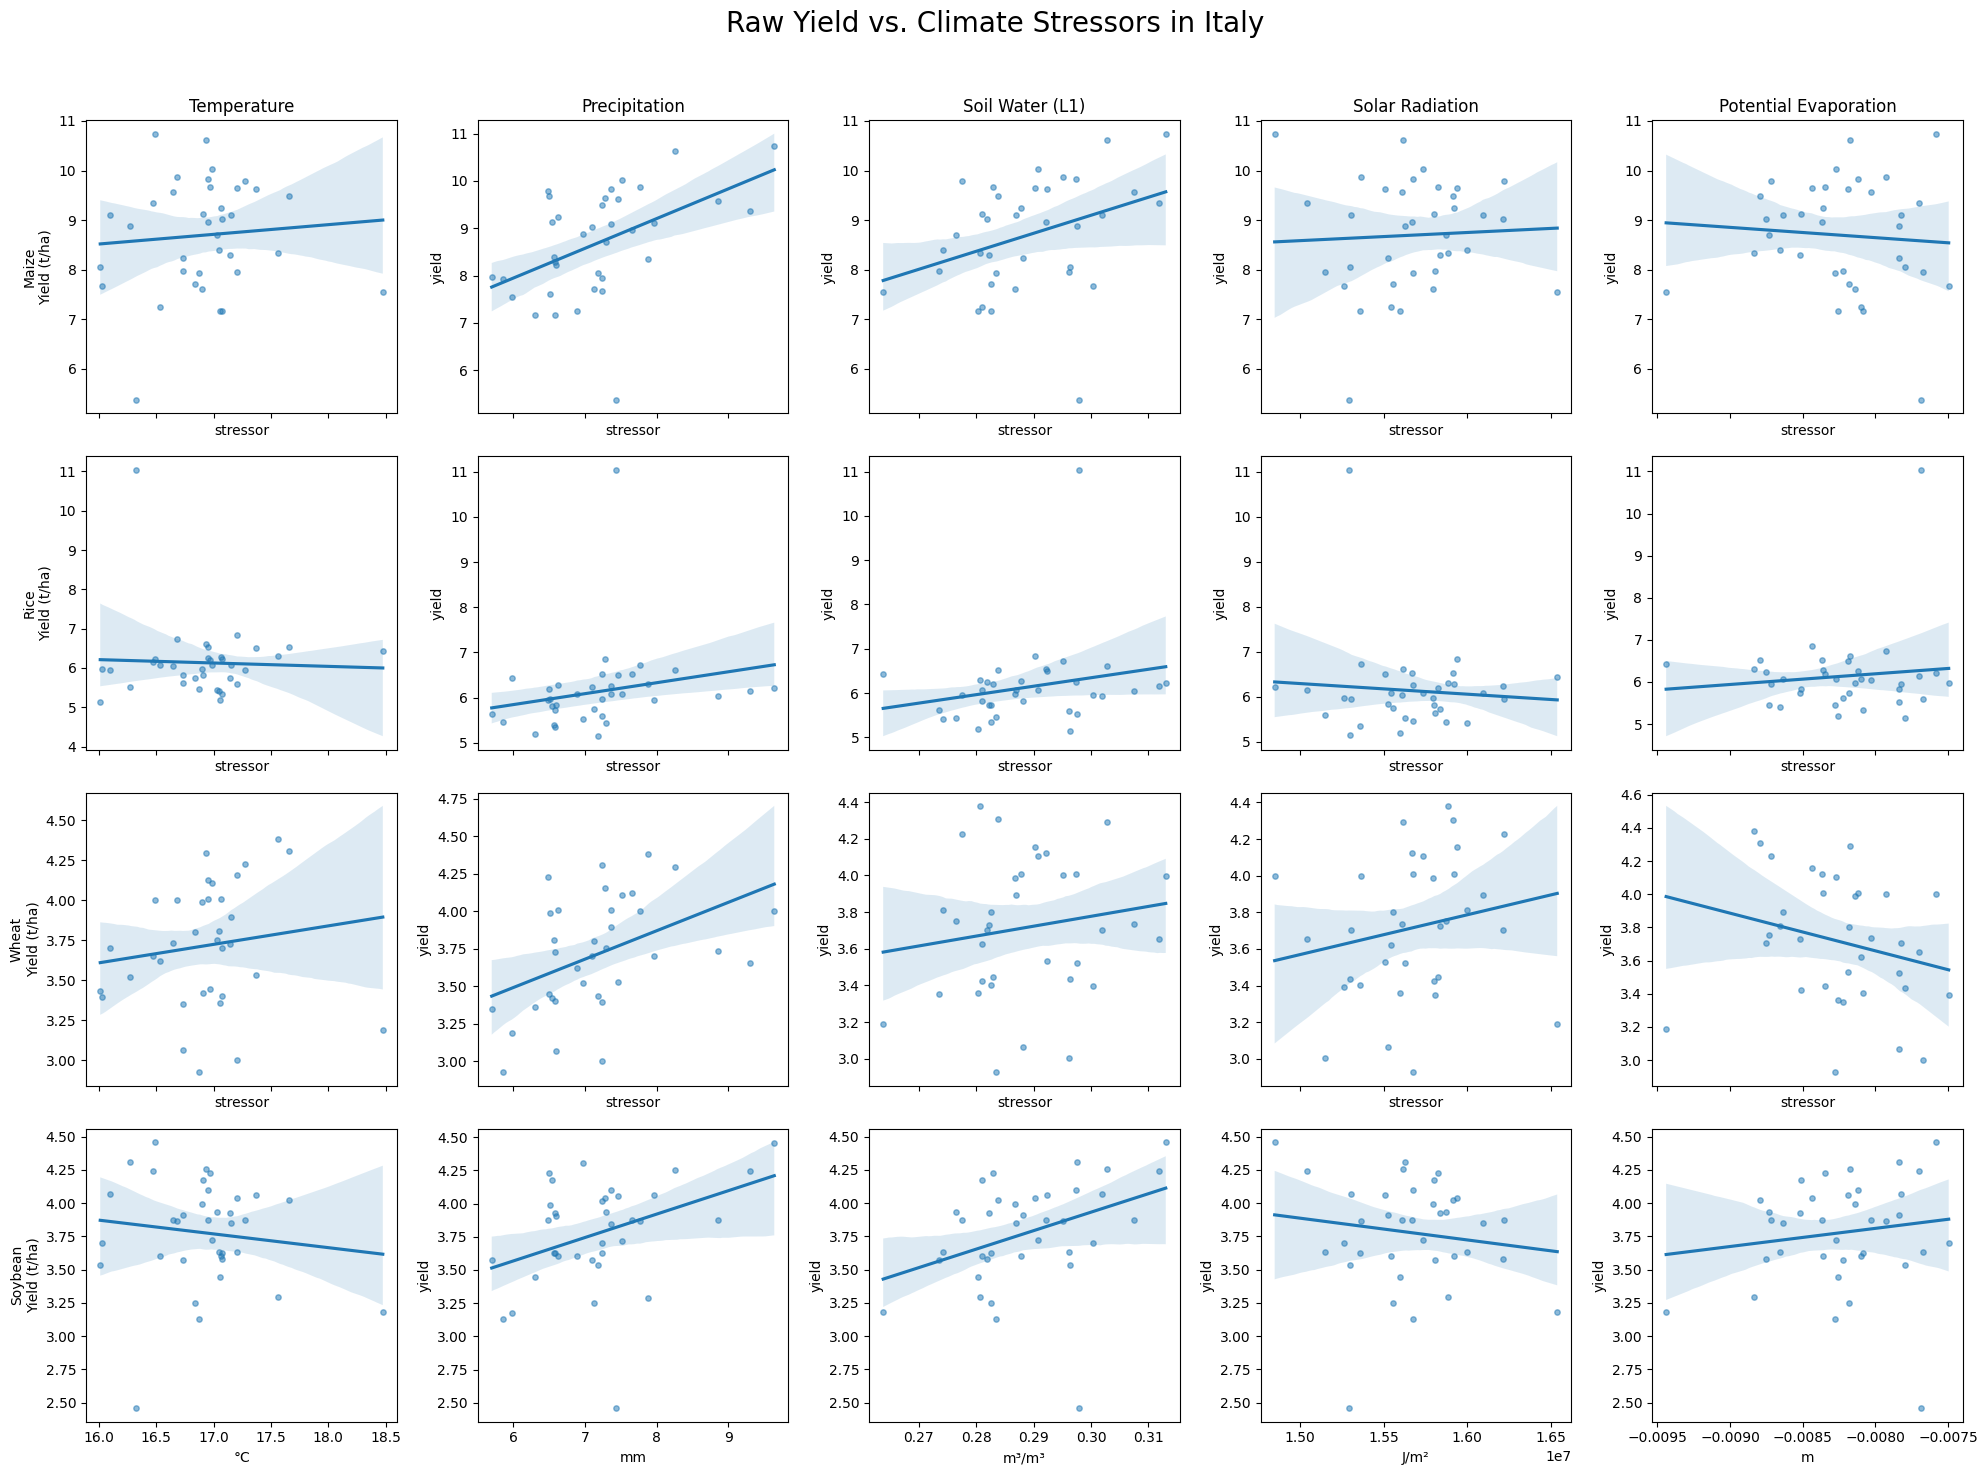


--- Generating dashboard for Peru ---


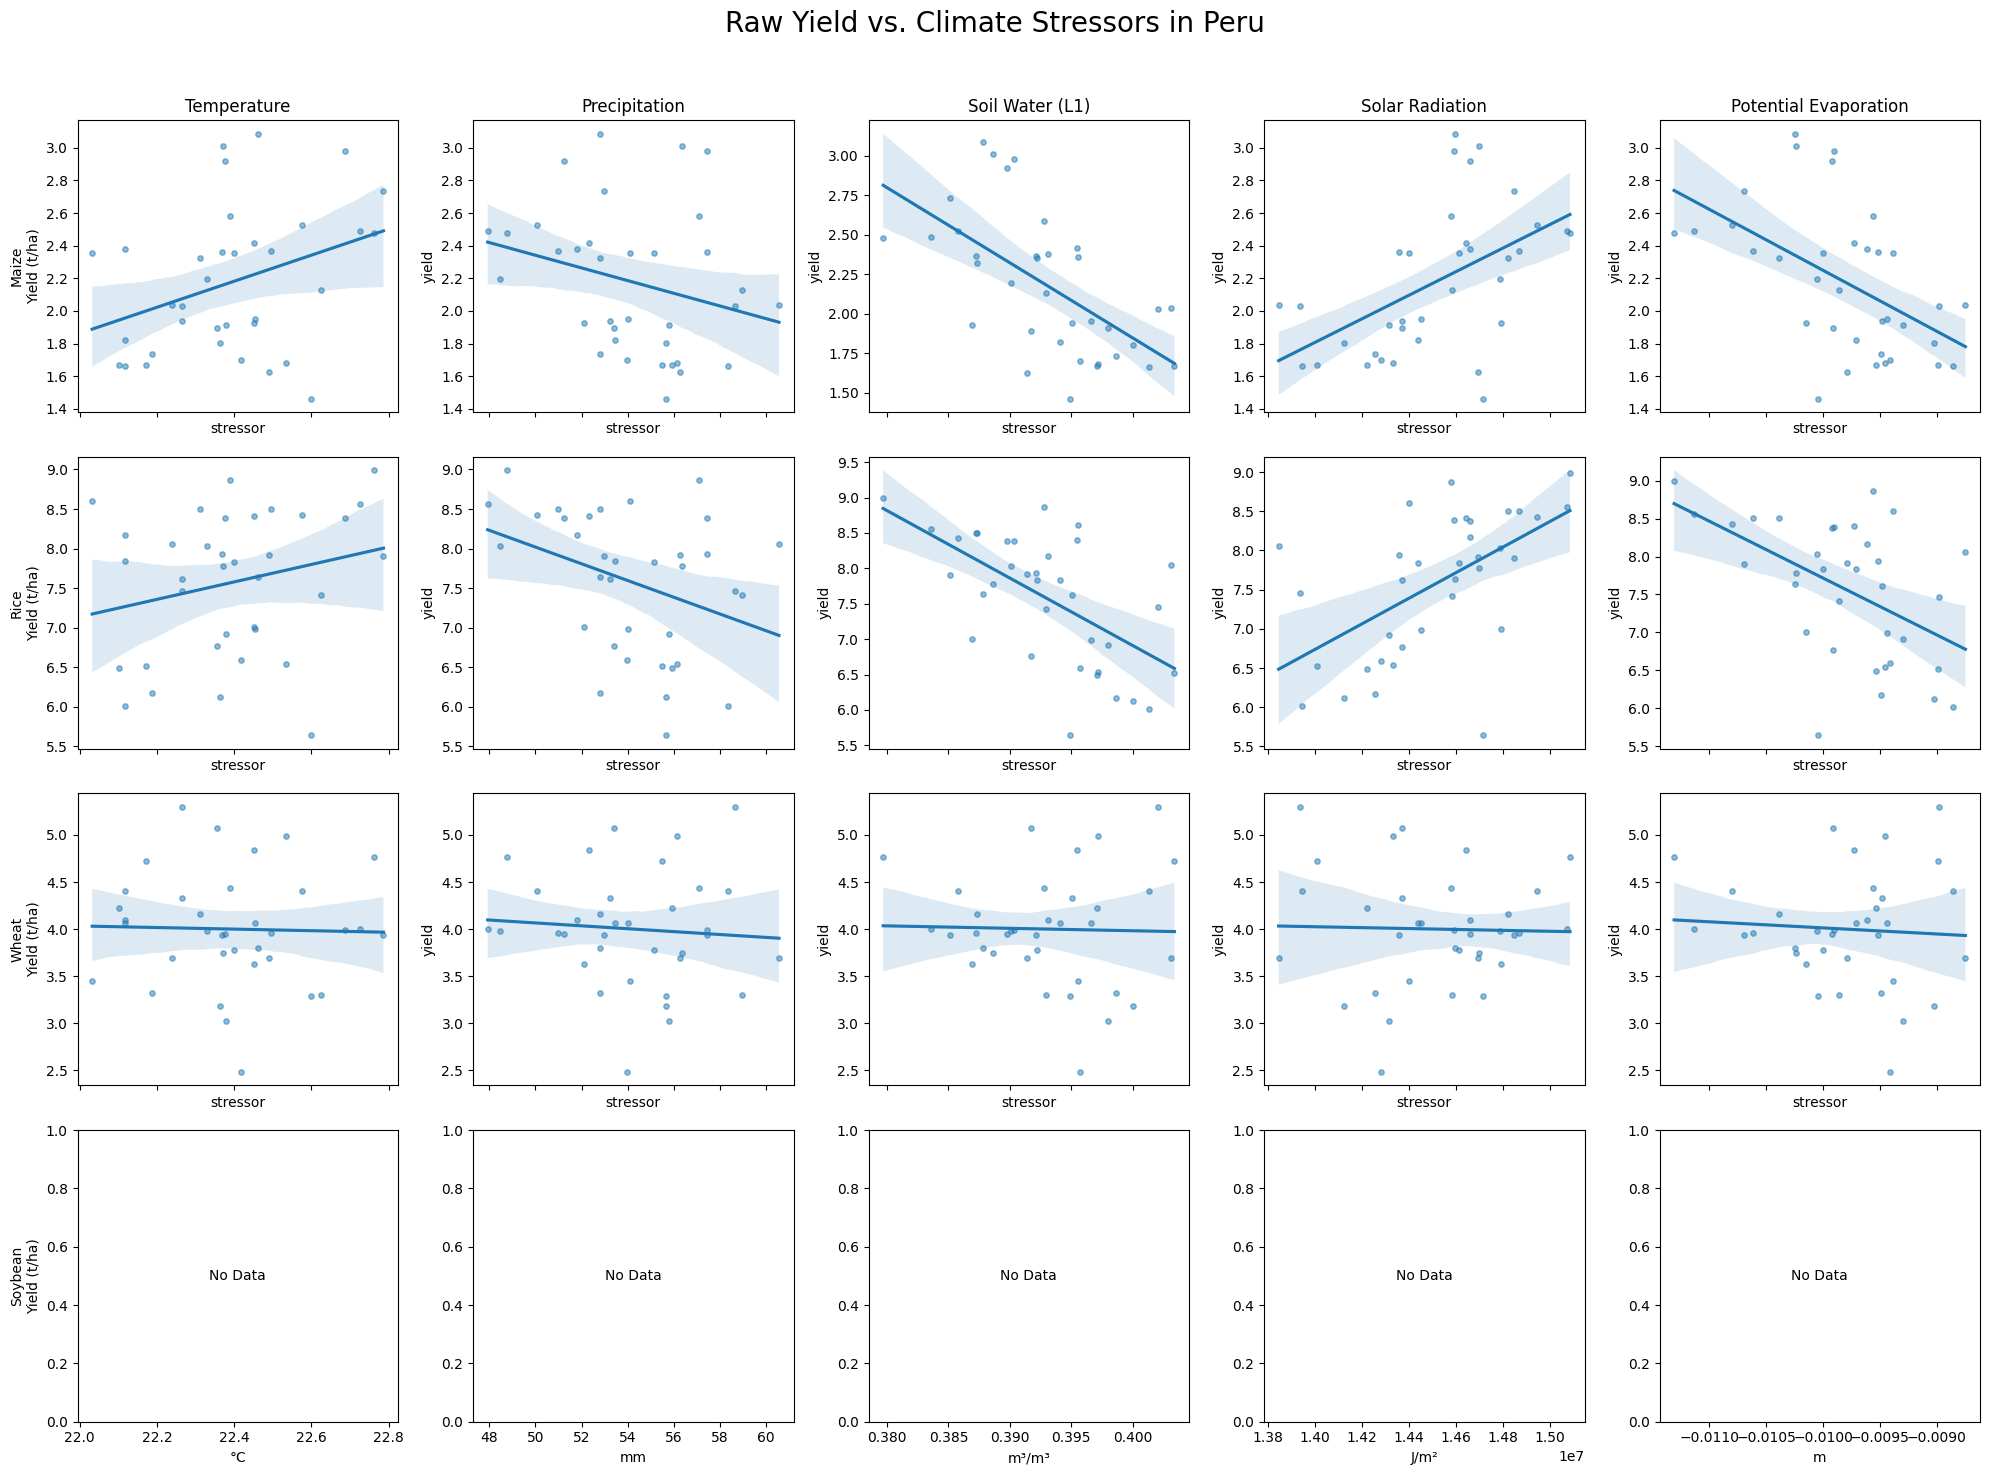


--- Generating dashboard for Chile ---


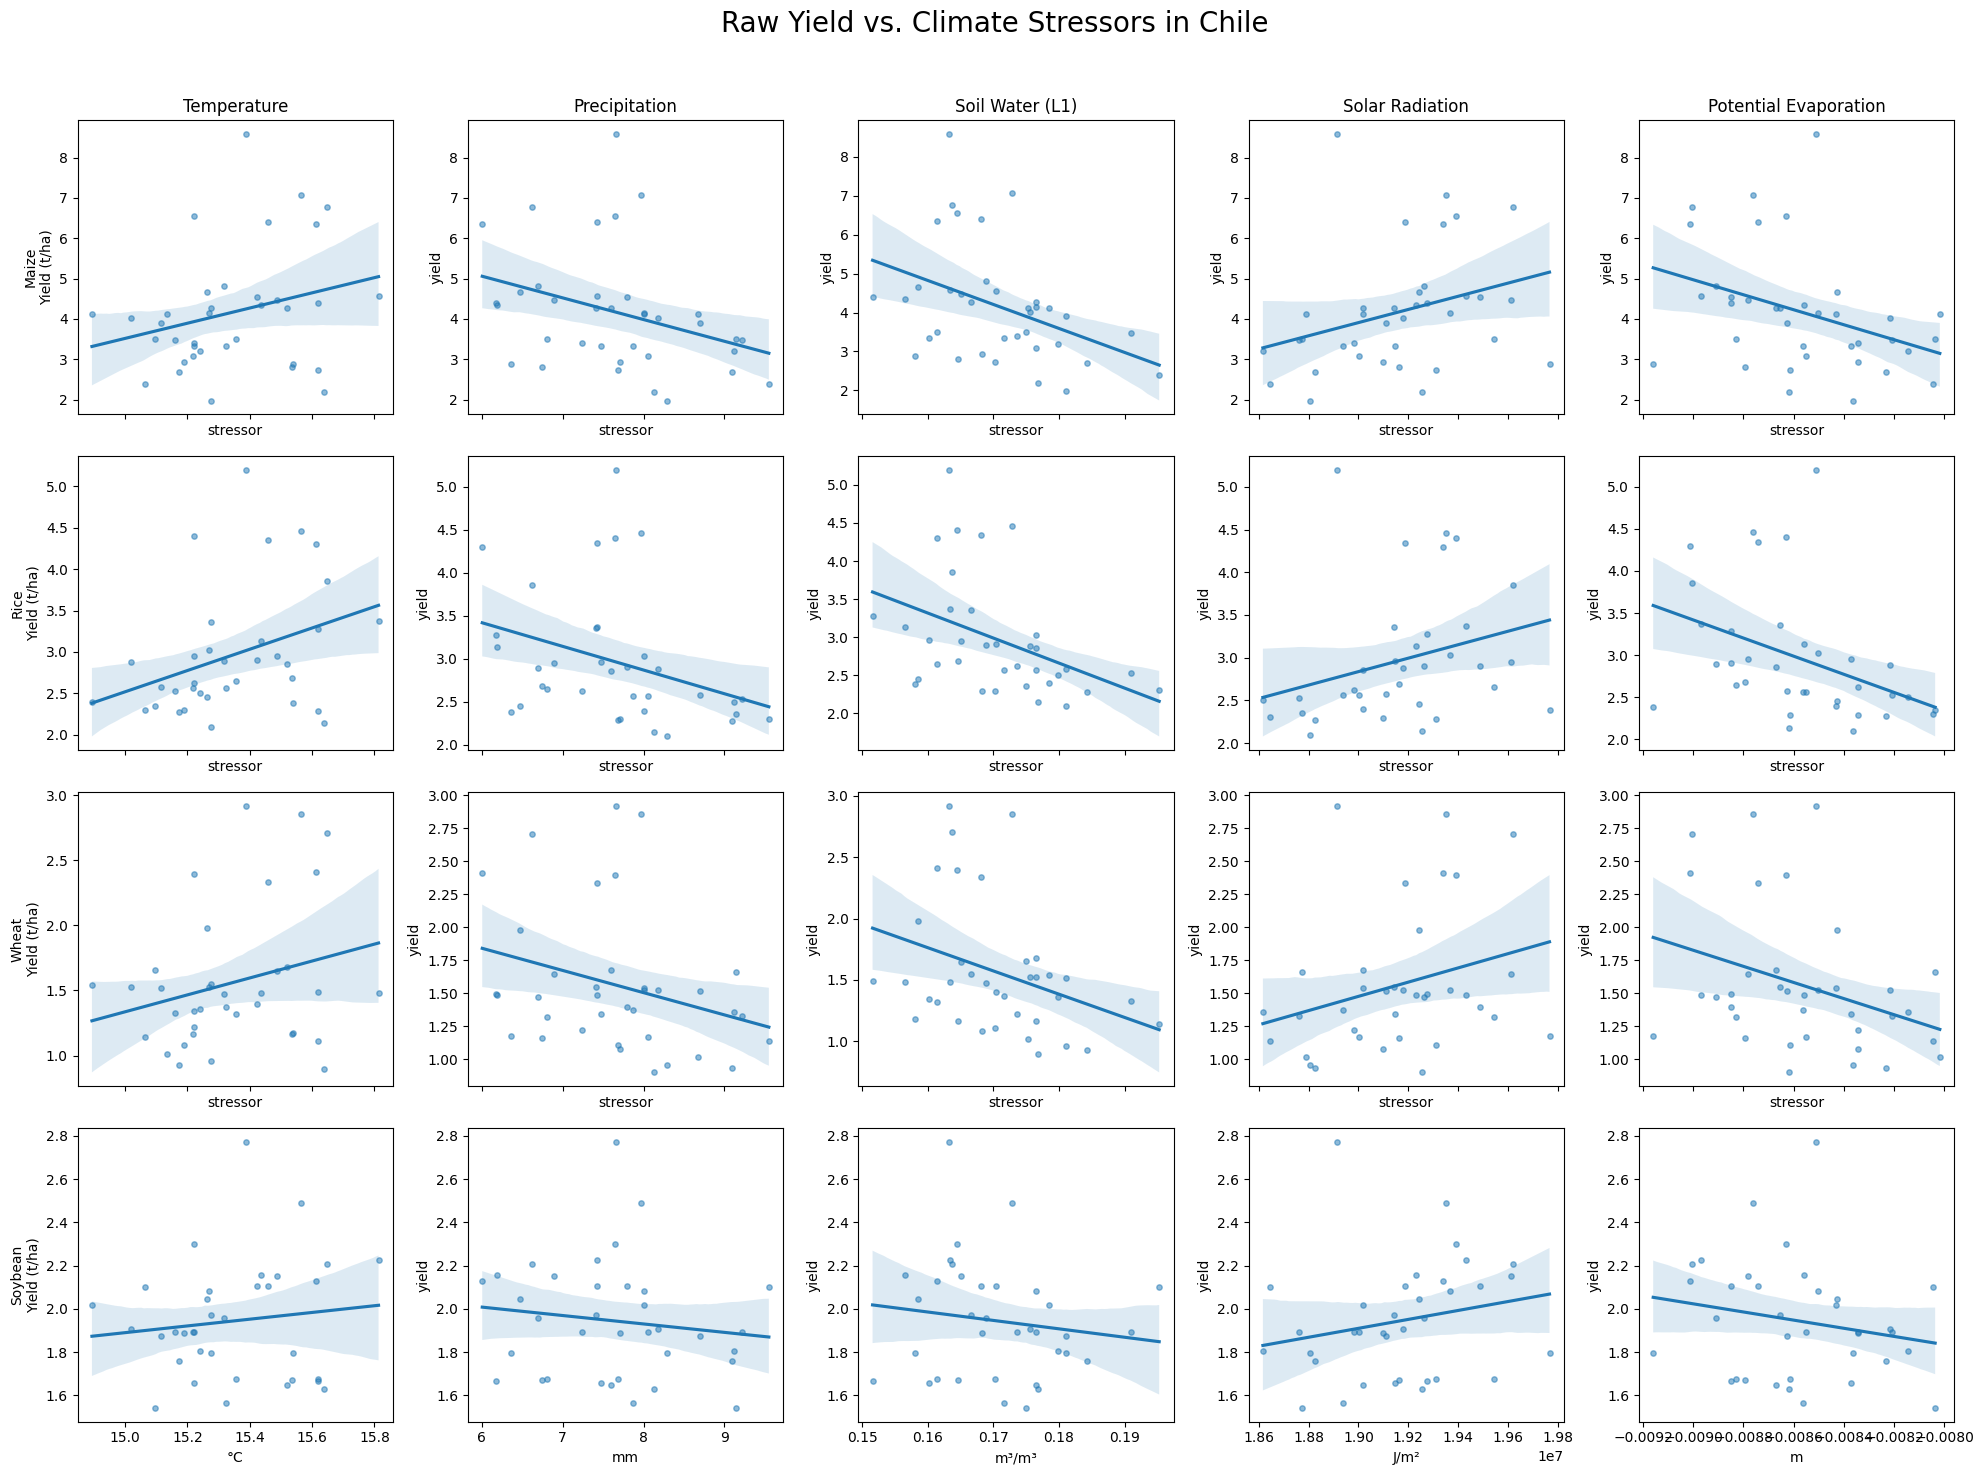


--- All dashboards generated! ---


In [1]:
# Cell 1: The Full Dashboard Generation Script
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import os

# --- 1. Load All Necessary Data (This may take a minute) ---
print("--- Loading all required datasets ---")

# Load all full yield datasets
CROPS = ['maize', 'rice', 'wheat', 'soybean']
full_yields = {}
for crop in CROPS:
    data_path = f'../data/{crop}/yield_*.nc4'
    filepaths = sorted(glob.glob(data_path))
    years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
    with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
        ds = ds.assign_coords(time=years)
        full_yields[crop] = ds['var'].compute()
print("Loaded all yield data.")

# Load all full climate datasets
CLIMATE_PATH_TEMPLATE = '../data/climate_monthly_full/era5_land_monthly_*.grib'
STRESSORS = {
    '2t': {'name': 'Temperature', 'units': '°C', 'agg': 'mean'},
    'tp': {'name': 'Precipitation', 'units': 'mm', 'agg': 'sum'},
    'swvl1': {'name': 'Soil Water (L1)', 'units': 'm³/m³', 'agg': 'mean'},
    'ssr': {'name': 'Solar Radiation', 'units': 'J/m²', 'agg': 'mean'},
    'pev': {'name': 'Potential Evaporation', 'units': 'm', 'agg': 'mean'}
}
full_climate = {}
for short_name in STRESSORS.keys():
    ds_var = xr.open_mfdataset(
        CLIMATE_PATH_TEMPLATE, engine='cfgrib', combine='nested', concat_dim='time',
        backend_kwargs={'filter_by_keys': {'shortName': short_name}}
    )
    full_climate[short_name] = ds_var.assign_coords(time=pd.to_datetime(ds_var.time.values))
print("Loaded all climate data.")

# --- 2. Define Regions and Growing Season ---
regions = {
    'China': {'lon': slice(73, 135), 'lat': slice(18, 54)},
    'Italy': {'lon': slice(6, 19), 'lat': slice(35, 47)},
    'Peru': {'lon': slice(279, 292), 'lat': slice(-18, 0)},
    'Chile': {'lon': slice(286, 296), 'lat': slice(-56, -17)}
}
climate_regions = {
    'China': {'longitude': slice(73, 135), 'latitude': slice(54, 18)},
    'Italy': {'longitude': slice(6, 19), 'latitude': slice(47, 35)},
    'Peru': {'longitude': slice(279, 292), 'latitude': slice(0, -18)},
    'Chile': {'longitude': slice(286, 296), 'latitude': slice(-17, -56)}
}
temp_celsius = full_climate['2t']['t2m'] - 273.15
growing_season_mask = temp_celsius > 10
print("Defined regions and growing season mask.")

# --- 3. Main Plotting Loop ---
for region_name, bounds in regions.items():
    print(f"\n--- Generating dashboard for {region_name} ---")
    fig, axes = plt.subplots(nrows=len(CROPS), ncols=len(STRESSORS), figsize=(20, 15), sharex='col')
    fig.suptitle(f'Raw Yield vs. Climate Stressors in {region_name}', fontsize=20)
    
    for i, crop_name in enumerate(CROPS):
        for j, (short_name, info) in enumerate(STRESSORS.items()):
            ax = axes[i, j]
            
            # --- Prepare Data for this plot ---
            regional_yield = full_yields[crop_name].sel(**bounds)
            
            if regional_yield.notnull().any():
                # 1. Get yield time-series (raw, not de-trended)
                weights = np.cos(np.deg2rad(regional_yield.lat))
                yield_ts = regional_yield.weighted(weights).mean(dim=('lat', 'lon'))
                
                # 2. Get climate time-series
                var_name = list(full_climate[short_name].data_vars)[0]
                regional_climate = full_climate[short_name][var_name].sel(**climate_regions[region_name])
                regional_mask = growing_season_mask.sel(**climate_regions[region_name])
                seasonal_data = regional_climate.where(regional_mask)
                
                # Apply the correct aggregation method
                if info['agg'] == 'sum':
                    yearly_stressor = seasonal_data.groupby('time.year').sum(dim='time').mean(dim=['latitude', 'longitude'])
                else: # 'mean'
                    yearly_stressor = seasonal_data.groupby('time.year').mean(dim='time').mean(dim=['latitude', 'longitude'])
                
                # Unit conversions
                if short_name == '2t': yearly_stressor -= 273.15
                if short_name == 'tp': yearly_stressor *= 1000

                # 3. Combine and Plot
                df = pd.DataFrame({'stressor': yearly_stressor.values, 'yield': yield_ts.values}).dropna()
                if not df.empty:
                    sns.regplot(data=df, x='stressor', y='yield', ax=ax,
                                scatter_kws={'alpha': 0.5, 's': 15})
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)

            # --- Formatting ---
            if j == 0: ax.set_ylabel(f"{crop_name.capitalize()}\nYield (t/ha)")
            if i == 0: ax.set_title(info['name'])
            if i == len(CROPS) - 1: ax.set_xlabel(info['units'])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("\n--- All dashboards generated! ---")